In [1]:
import sys
sys.path.insert(0, "..")

from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
daily_input = pd.read_csv(path+nb_name[:-6]+'.csv', index_col=0, parse_dates=True)

In [5]:
daily_input

,T,T5,T25,T75,T95,E,E5,E25,E75,E95,...,P5,P25,P75,P95,S,S5,S25,S75,S95,Q
1985-04-30,274.750407,270.460059,272.525867,276.526203,279.539211,1.926444,0.916188,1.286878,2.523418,3.099490,...,0.811537,1.395932,4.121388,6.127313,237.400000,0.0,7.5,380.5,479.4,NaN
1985-05-01,277.088152,273.152393,275.067035,278.808027,281.578507,2.217360,1.324982,1.695870,2.765906,3.200672,...,-0.008446,-0.002171,0.213096,0.610340,234.266667,0.0,2.5,377.5,475.2,NaN
1985-05-02,275.148650,270.989175,273.139689,276.934687,279.599276,1.496606,0.740481,0.985599,1.962432,2.323539,...,3.833838,5.148251,11.044787,12.763188,236.200000,0.0,0.0,381.5,478.7,NaN
1985-05-03,273.274769,268.613240,271.133766,275.187411,277.973596,1.882182,0.895435,1.310193,2.445402,2.865194,...,-0.009772,0.102490,1.055105,1.730351,236.533333,0.0,0.0,382.0,480.0,NaN
1985-05-04,273.785826,269.856606,272.110671,275.441825,277.504687,1.253490,0.540235,0.853378,1.720379,1.800337,...,1.247874,2.153692,4.614390,6.526817,236.933333,0.0,0.0,383.5,482.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,271.286735,268.268511,269.470292,273.599553,274.513983,0.387947,0.275761,0.311288,0.458379,0.503298,...,0.000487,0.006801,0.038146,0.160409,50.666667,0.0,6.0,82.0,142.2,21.342
2018-11-27,271.933944,268.843288,270.142067,274.296183,275.251790,0.608764,0.440679,0.490556,0.699907,0.776674,...,0.010018,0.022661,0.320281,0.507988,50.533333,0.0,4.5,82.0,142.5,21.060
2018-11-28,271.020687,267.691434,268.993718,273.488415,274.456598,0.462649,0.328091,0.357282,0.510741,0.644603,...,-0.000869,-0.000091,-0.000017,-0.000007,50.400000,0.0,4.0,82.0,142.5,20.315
2018-11-29,272.327900,269.668823,270.692635,274.519667,275.710756,-0.135456,-0.341666,-0.218891,-0.081519,0.092991,...,-0.000678,-0.000097,-0.000034,-0.000006,50.266667,0.0,3.0,82.0,142.5,20.615


In [4]:
t_unit=10

#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-2, -1, 7)
epsilon_range=np.logspace(-4, -2.8, 4)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=4
test_size=365*2

Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits

C=0.1
eps=0.001


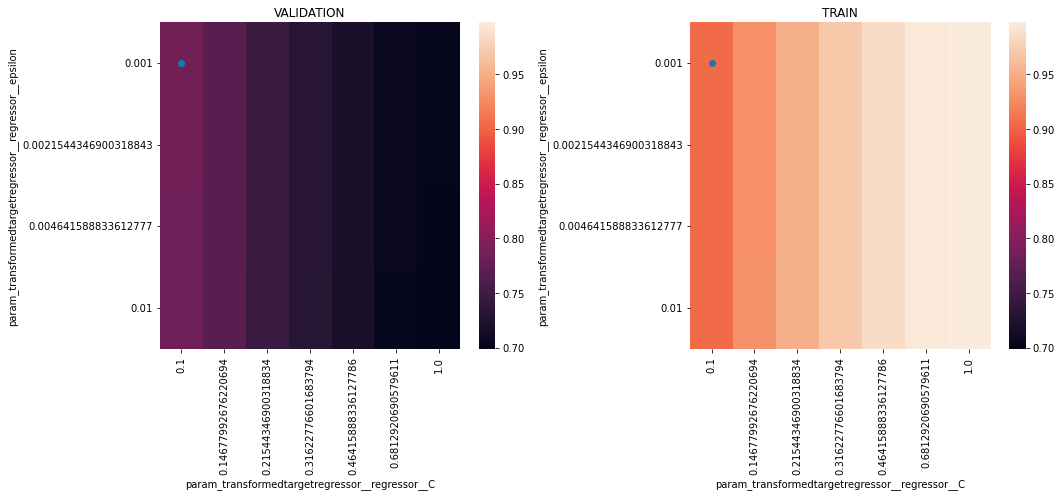

In [9]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [11]:
C_range=np.logspace(-2, -1, 7)
epsilon_range=np.logspace(-4, -2.8, 4)

Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits
Fitting 1 folds for each of 28 candidates, totalling 28 fits

C=0.06812920690579612
eps=0.0001


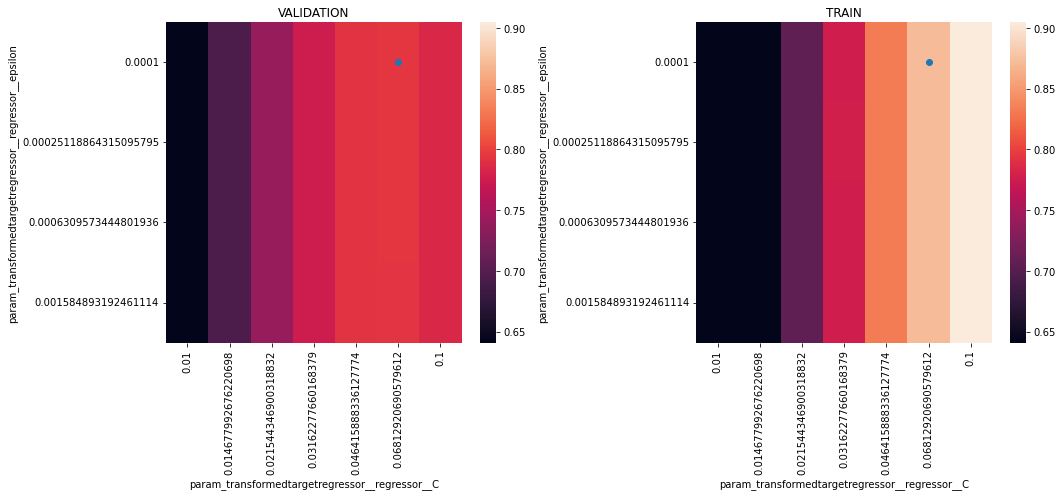

In [12]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [6]:
C=0.06812920690579612
eps=0.0001

In [7]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

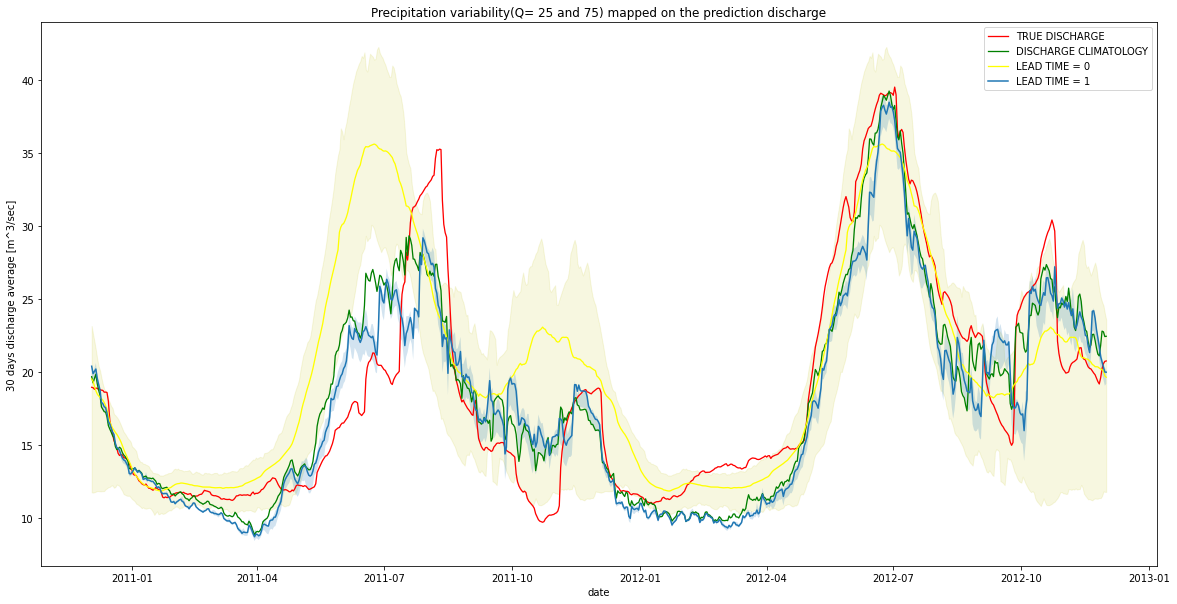

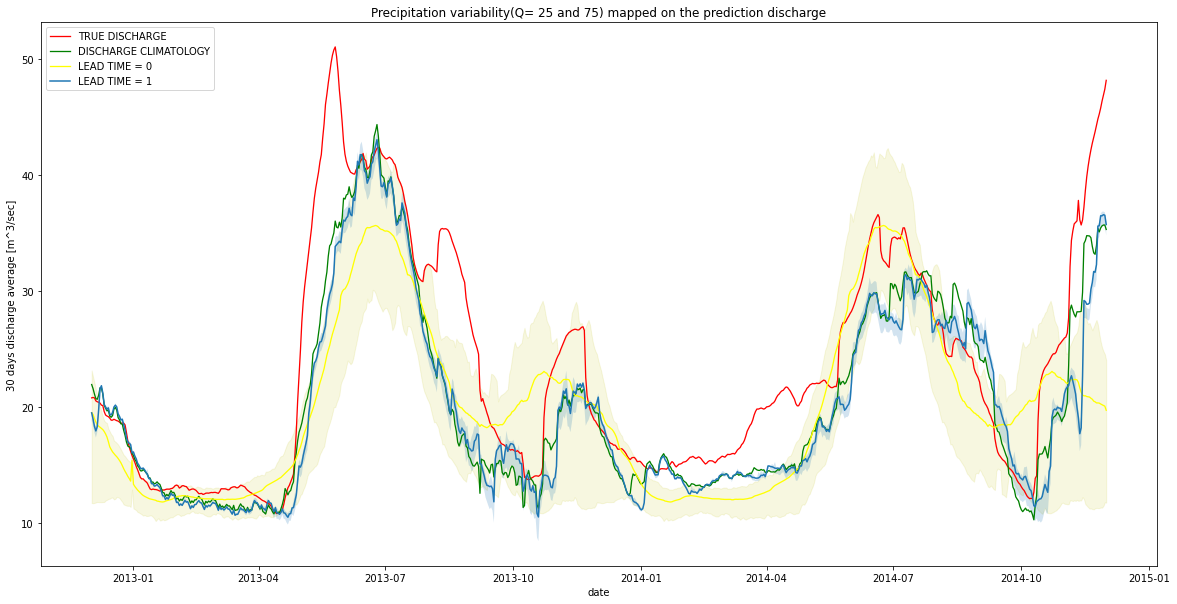

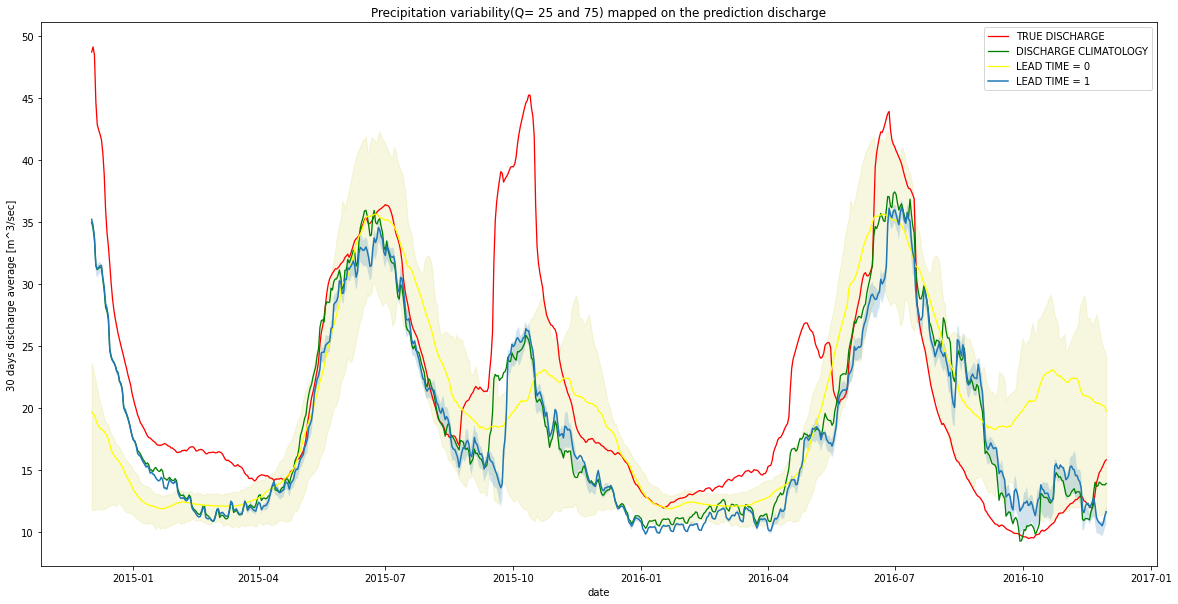

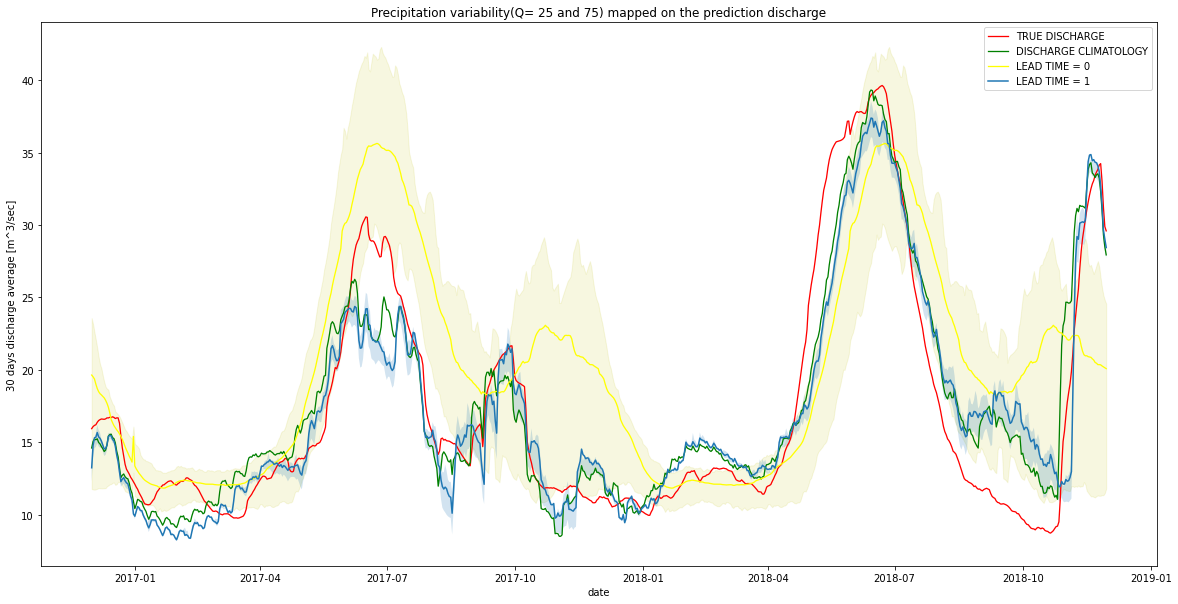

In [8]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)


measured runoff             1.000000
runoff climatology          0.470122
runoff_clim_25              0.106814
runoff_clim_75              0.250086
model output                0.777450
output 1 month lead time    0.714325
output 2 month lead time    0.607440
output 3 month lead time    0.478145
output 4 month lead time    0.431175
output 5 month lead time    0.403734
dtype: float64

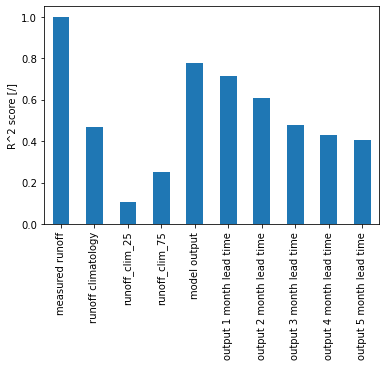

In [9]:
evaluate_prediction(predictions)

measured runoff             1.000000
runoff climatology          0.470122
model output                0.765559
output 1 month lead time    0.697853
output 2 month lead time    0.589761
output 3 month lead time    0.458673
output 4 month lead time    0.418067
output 5 month lead time    0.393185
dtype: float64

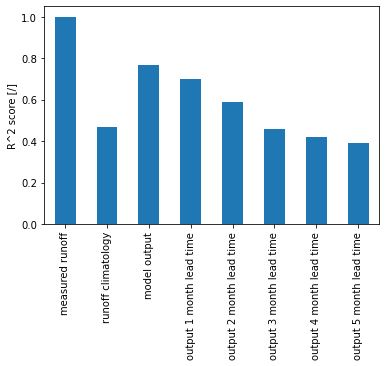

In [15]:
#old
evaluate_prediction(predictions)

In [10]:
from test import evaluate_class, evaluate_class_season
clas=evaluate_class_season(predictions)
clas.index=np.repeat(nb_name[:-6],4)
clas.to_csv('class_res.csv', mode='a', header=False)

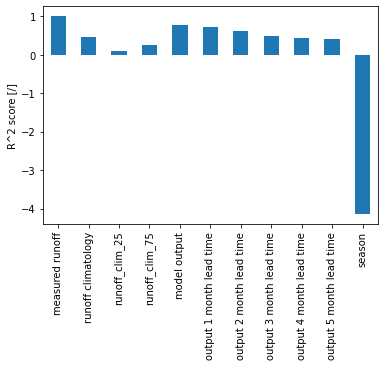

In [11]:
r=pd.DataFrame(evaluate_prediction(predictions)).transpose()
r['STAT_CODE']=(nb_name[:-6])
r.index=r.STAT_CODE
r.drop(columns=['season','runoff_clim_25','runoff_clim_75','STAT_CODE'],inplace=True)
r.to_csv('r_res.csv',mode='a',header=False)

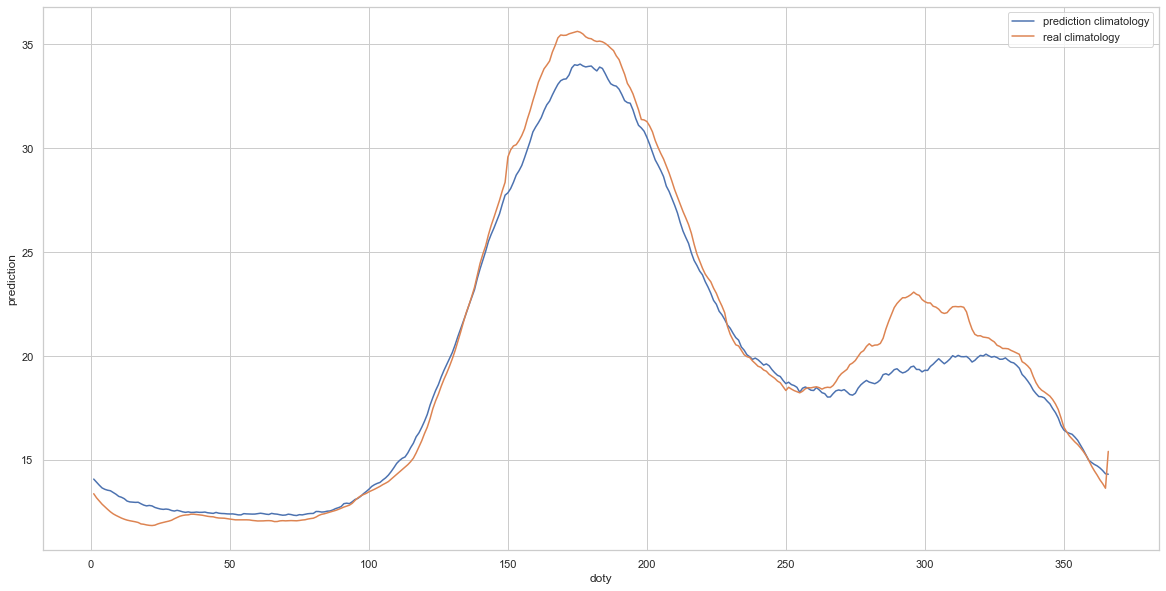

In [13]:
predictions_for_clim = classic_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits)
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index

sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

In [14]:
from db_insert import insert
insert(nb_name[:-6],predictions_for_clim)

In [15]:
##develop model savior

from sklearn.svm import SVR, LinearSVR
from sf_runoff import create_it_matrix
from joblib import dump, load

it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

X = it_matrix.drop(columns='Q')
y = it_matrix['Q']
svr_estimator = SVR(kernel='rbf', gamma='scale', cache_size=15000,C=C,epsilon=eps)

svr_estimator = make_pipeline(StandardScaler(),
                              TransformedTargetRegressor(regressor=svr_estimator, transformer=StandardScaler()))

svr_estimator.fit(X, y)

path='models/'+nb_name[:-6]+'.joblib'

dump(svr_estimator, path)

['models/ADO_DSC_CH07_0147.joblib']